# Nonlinear Fitting

What about the case of fitting to a function where the fit parameters enter in a nonlinear fashion?
For example:

$$f(x; a_0, a_1) = a_0 e^{a_1 x}$$

One trick that is often used for something like this is to transform the data.  So instead of fitting the data $(x_i, y_i)$, you instead fit $(x_i, \log y_i)$, and then our fitting function is:

$$\log f(x; a_0, a_1) = a_1 x + \log a_0$$

which is linear.

However, when there are errors associated with the $y_i$, the errors do not necessarily transform the correct way when you take the logarithm.  

So let's look at how we would fit directly to a nonlinear function.

We'll minimize the same fitting function:

$$\chi^2 = \sum_{i=1}^N \frac{(y_i - f(x; {\bf a}))^2}{\sigma_i^2}$$

with fitting parameters ${\bf a} = (a_1, \ldots, a_M)^\intercal$.

Now we take the derivatives with respect to each paramter, $a_k$:

$$\frac{\partial \chi^2}{\partial a_k} = 2 \sum_{i=1}^N \frac{(y_i - f(x, {\bf a}))}{\sigma_i^2} \frac{\partial f}{\partial a_k} = 0$$

Let's define $g_k \equiv {\partial \chi^2}/{\partial a_k}$, then we have

$${\bf g}({\bf a}) = \left ( \begin{array}{c} g_1({\bf a}) \\ g_2({\bf a}) \\ \vdots \\ g_M({\bf a}) \end{array} \right ) = 0$$

This is a nonlinear system of $M$ equations and $M$ unknowns.  We can solve this using the same multivariate Newton's method we looked at before:

* Take an initial guess at the fit parameters, ${\bf a}^{(k)}$
* Solve the system ${\bf J}\delta {\bf a} = -{\bf g}$, where $J_{ij} = \partial g_i/\partial a_j$ is the Jacobian
* Correct the initial guess, ${\bf a}^{(k+1)} = {\bf a}^{(k)} + \delta {\bf a}$

As we've seen with Newton's method, convergence will be very sensitive to the initial guess.

## Fitting an exponential

Let's try this out on data that is constructed to follow an exponential trend.

First let's construct the data, and perturb it with some errors.  We'll take the form:

$$y = a_0 e^{a_1 x}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<ErrorbarContainer object of 3 artists>

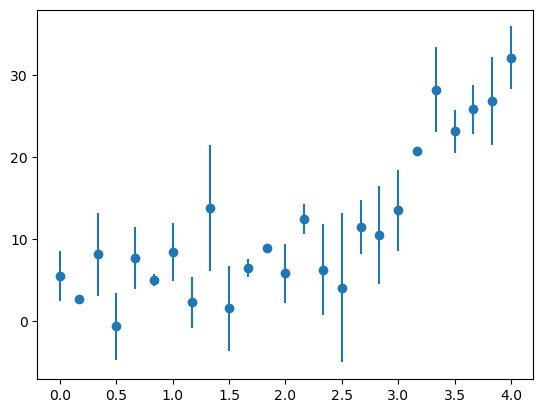

In [3]:
# make up some experimental data
a0 = 2.5
a1 = 2./3.
sigma = 4.0

N = 25

x = np.linspace(0.0, 4.0, N)
r = sigma * np.random.randn(N)
y = a0 * np.exp(a1 * x) + r
yerr = np.abs(r)

fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=yerr, fmt="o")

Now, let's compute our vector ${\bf g}$ that we will zero:

\begin{align*}
g_0 &= \frac{\partial \chi^2}{\partial a_0} = 2 \sum_{i=1}^N \frac{(y_i - a_0 e^{a_1 x_i})}{\sigma_i^2} (e^{a_1 x_i}) \\
g_1 &= \frac{\partial \chi^2}{\partial a_1} = 2 \sum_{i=1}^N \frac{(y_i - a_0 e^{a_1 x_i})}{\sigma_i^2} (x_i a_0 e^{a_1 x_i})
\end{align*}

We can divide out the $2$ in each expression, and in $g_1$, we can also divide out the overall $a_0$ factor.

Let's write a function to compute this:

In [4]:
def g(x, y, yerr, a):
    """compute the nonlinear functions we minimize.  Here a is the vector
    of fit parameters"""
    
    a0, a1 = a
    
    g0 = np.sum(np.exp(a1 * x) * (y - a0 * np.exp(a1 * x)) / yerr**2)
    g1 = np.sum(x * np.exp(a1 * x) * (y - a0 * np.exp(a1 * x)) / yerr**2)
    
    return np.array([g0, g1])

We also need the Jacobian.  We could either compute this numerically, via differencing, or analytically.  We'll do the latter.

\begin{align*}
\frac{\partial g_0}{\partial a_0} &= -\sum_{i=1}^N \frac{e^{2a_1 x_i}}{\sigma_i^2} \\
\frac{\partial g_0}{\partial a_1} &= \sum_{i=1}^N \frac{x_i e^{a_1 x_i} (y_i - 2 a_0 e^{a_1 x_i})}{\sigma_i^2} \\
\frac{\partial g_1}{\partial a_0} &= -\sum_{i=1}^N \frac{x_i e^{2a_1 x_i}}{\sigma_i^2} \\
\frac{\partial g_2}{\partial a_1} &= \sum_{i=1}^N \frac{x_i^2 e^{a_1 x_i} (y_i - 2 a_0 e^{a_1 x_i})}{\sigma_i^2}
\end{align*}

Let's write this function:

In [5]:
def jac(x, y, yerr, a):
    """ compute the Jacobian of the function g"""

    a0, a1 = a
    
    dg0da0 = -np.sum(np.exp(2.0 * a1 * x) / yerr**2)
    dg0da1 = np.sum(x * np.exp(a1 * x) * (y - 2.0 * a0 * np.exp(a1 * x)) / yerr**2)
    dg1da0 = -np.sum(x * np.exp(2.0 * a1 * x) / yerr**2)
    dg1da1 = np.sum(x**2 * np.exp(a1 * x) * (y - 2.0 * a0 * np.exp(a1 * x)) / yerr**2)
    
    return np.array([[dg0da0, dg0da1],
                     [dg1da0, dg1da1]])

In [6]:
def fit(aguess, x, y, yerr, tol=1.e-5):
    """ aguess is the initial guess to our fit parameters.  x and y
        are the vector of points that we are fitting to, and yerr are
        the errors in y"""
    
    avec = aguess.copy()

    err = 1.e100
    while err > tol:

        # get the jacobian
        J = jac(x, y, yerr, avec)

        print("condition number of J: ", np.linalg.cond(J))

        # get the current function values
        gv = g(x, y, yerr, avec)

        # solve for the correction: J da = -g
        da = np.linalg.solve(J, -gv)

        avec += da
        err = np.max(np.abs(da))

    return avec

In [7]:
# initial guesses
aguess = np.array([1.0, 1.0])

# fit
afit = fit(aguess, x, y, yerr)

condition number of J:  864.2269906228349
condition number of J:  220.80059270361377
condition number of J:  365.1523933798512
condition number of J:  348.4365822378732
condition number of J:  347.9856151627861


In [8]:
afit

array([2.4629157 , 0.67292233])

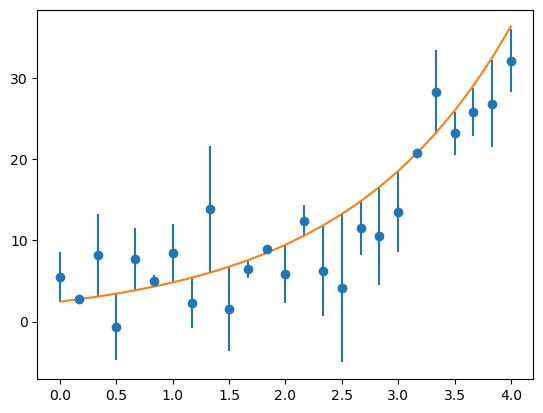

In [9]:
ax.plot(x, afit[0] * np.exp(afit[1] *x))
fig